In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Colab Notebooks/Deep_Learning_Face_mask_detection/'

Mounted at /content/drive


In [2]:
# # Define path to save the file
# save_path = file_path + '/face_mask_data.npz'

# # Save numpy arrays
# np.savez_compressed(save_path, images=face_images, labels=face_labels)

# print(f"Data saved successfully to {save_path}")

In [3]:
# Load dataset
loaded_data = np.load(file_path + 'face_mask_data.npz')

# Extract images and labels
face_images = loaded_data['images']
face_labels = loaded_data['labels']

print("Data loaded successfully!")
print(face_images.shape, face_labels.shape)


Data loaded successfully!
(4072, 224, 224, 3) (4072,)


In [4]:
train_x, test_val_x, train_y, test_val_y = train_test_split(face_images, face_labels, test_size=0.3, shuffle=True, stratify=face_labels)
test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, test_size=0.5, shuffle=True, stratify=test_val_y)

print(train_x.shape, val_x.shape, test_x.shape)
print(train_y.shape, val_y.shape, test_y.shape)


(2850, 224, 224, 3) (611, 224, 224, 3) (611, 224, 224, 3)
(2850,) (611,) (611,)


In [5]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)
test_y = to_categorical(test_y, num_classes=3)

print(train_y.shape, val_y.shape, test_y.shape)  # Should print (2850, 3), (611, 3), (611, 3)

(2850, 3) (611, 3) (611, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers (adjusted Dense size)
        layers.Dense(512, activation='relu'),  # Reduced size to prevent OOM
        layers.Dropout(0.5),  # Dropout for regularization
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Build the model
model = build_cnn_model()
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping


# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.8579 - loss: 0.6530 - val_accuracy: 0.9313 - val_loss: 0.2282
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9303 - loss: 0.2174 - val_accuracy: 0.9198 - val_loss: 0.2255
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9347 - loss: 0.1910 - val_accuracy: 0.9264 - val_loss: 0.2139
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9146 - loss: 0.2718 - val_accuracy: 0.9362 - val_loss: 0.2010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9493 - loss: 0.1590 - val_accuracy: 0.9362 - val_loss: 0.1824
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9488 - loss: 0.1502 - val_accuracy: 0.9362 - val_loss: 0.2276
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9549 - loss: 0.1446 - val_accuracy: 0.9378 - val_loss: 0.1937
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9629 - loss: 0.1265 - val_accuracy: 0.9460 -

In [11]:
# Evaluate model performance on test data
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9497 - loss: 0.1405
Test Accuracy: 0.9476


In [12]:
import numpy as np

# Get predictions
pred_probs = model.predict(test_x)  # Get probability scores
pred_classes = np.argmax(pred_probs, axis=1)  # Convert to class labels

# Convert test_y to labels if it's one-hot encoded
if test_y.ndim == 2:
    test_y_labels = np.argmax(test_y, axis=1)
else:
    test_y_labels = test_y


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


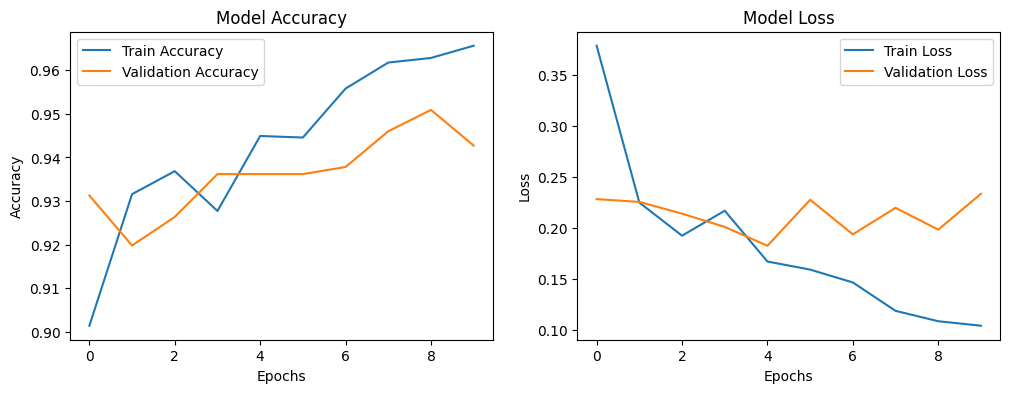

In [13]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()
